<a href="https://colab.research.google.com/github/dvigatelizm/keis7/blob/main/case7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кейс 7 Обученная модель бинарной классификации, определяющая вероятность отказа оборудования
## Нужно предсказать, произойдёт ли отказ оборудования на основе его технических характеристик, условий эксплуатации и истории работы

- Импорт и анализ исторических данных
- Предобработка и очистка данных
- Обучение модели (SVM, деревья решений)
- Оценка метрик precision, recall, ROC-AUC

###  Участники
- Скрипин Сергей
- Яньшин Александр
- Ненилин Владислав
- Дроздюков Владимир
- Исангузин Ильдар
- Валиуллин Эдуард Римович

# библиотеки для анализа данных и визуализации:

- `pandas` - работа с табличными данными
- `seaborn` - статистическая визуализация
- `matplotlib.pyplot` - построение графиков
- `numpy` - математические операции и работа с массивами

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import requests
from io import StringIO



# Загрузка данных

- Загружается CSV файл `train.csv` в DataFrame `df`
- Файл содержит обучающие данные для анализа
- Данные теперь доступны в переменной `df` для дальнейшего исследования и визуализации

In [ ]:
url = "https://raw.githubusercontent.com/dvigatelizm/keis7/main/train.csv"
response = requests.get(url, verify=False)
df = pd.read_csv(StringIO(response.text))


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# Анализ структуры данных

Метод `df.info()` покажет:

## Основную информацию:
- Количество строк (наблюдений)
- Количество столбцов (признаков)
- Имена всех столбцов
- Типы данных каждого столбца (int64, float64, object и т.д.)
- Количество non-null значений в каждом столбце
- Объем используемой памяти

## Что это даст:
- Понимание полноты данных (пропуски)
- Определение типов переменных (числовые/категориальные)
- Оценка общего размера датасета
- Выявление потенциальных проблем с типами данных

In [ ]:
# Посмотрим на столбцы и типы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

## Общая информация:
- **136,429 записей** (строк)
- **14 столбцов** (признаков)
- **Пропуски:** нет

## Столбцы и типы данных:

### Числовые признаки:
**Вещественные (float64):**
- `Air temperature [K]`
- `Process temperature [K]`
- `Torque [Nm]`

**Целочисленные (int64):**
- `id`
- `Rotational speed [rpm]`
- `Tool wear [min]`
- `Machine failure`
- `TWF`, `HDF`, `PWF`, `OSF`, `RNF`

### Категориальные (object):
- `Product ID`
- `Type`



# Проверка дубликатов

In [ ]:
df.duplicated().sum()

NameError: name 'df' is not defined

**Результат:** 0

##  **Структура данных:**
# Расшифровка столбцов датасета

##  **Идентификаторы:**
- `id` - Уникальный числовой идентификатор записи
- `Product ID` - Идентификатор продукта/оборудования (формат: буква + цифры)
- `Type` - Тип оборудования (категория: L, M, H - Low/Medium/High)

## **Технологические параметры:**
- `Air temperature [K]` - Температура окружающего воздуха в Кельвинах
- `Process temperature [K]` - Технологическая температура процесса в Кельвинах
- `Rotational speed [rpm]` - Скорость вращения в оборотах в минуту
- `Torque [Nm]` - Крутящий момент в Ньютон-метрах
- `Tool wear [min]` - Износ инструмента в минутах работы

##  **Признаки отказов:**
- `Machine failure` - Общий индикатор отказа оборудования (1 - отказ, 0 - норма)
- `TWF` - Tool Wear Failure (Отказ из-за износа инструмента)
- `HDF` - Heat Dissipation Failure (Отказ теплоотвода)
- `PWF` - Power Failure (Отказ питания)
- `OSF` - Overstrain Failure (Отказ из-за перегрузки)
- `RNF` - Random Failures (Случайные отказы)



In [ ]:
df.sample(15) #  *Структура данных:*

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
49672,49672,L54777,L,300.5,311.0,1454,46.2,7,0,0,0,0,0,0
4413,4413,L54093,L,300.7,311.2,1481,50.4,181,0,0,0,0,0,0
132574,132574,L52510,L,303.6,312.8,1376,50.8,53,0,0,0,0,0,0
38135,38135,L52527,L,303.3,312.5,1486,34.4,100,0,0,0,0,0,0
129053,129053,L50398,L,300.6,309.6,1548,36.3,66,0,0,0,0,0,0
124276,124276,L52809,L,302.7,312.2,1386,51.4,157,0,0,0,0,0,0
25963,25963,M15545,M,297.7,309.0,1434,43.9,32,0,0,0,0,0,0
114647,114647,L56758,L,299.4,310.8,1551,40.3,7,0,0,0,0,0,0
51535,51535,L48566,L,298.9,310.3,1368,48.0,148,0,0,0,0,0,0
13881,13881,L48810,L,297.9,307.9,1537,37.6,5,0,0,0,0,0,0


Удаляем ID т.к. неролевантные данные

In [ ]:
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

df.sample(15)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
101237,L53136,L,300.7,310.9,1368,51.3,113,0,0,0,0,0,0
96942,L55768,L,297.3,307.8,1811,24.3,156,0,0,0,0,0,0
82205,L48625,L,299.0,310.0,1618,27.9,193,0,0,0,0,0,0
110892,L49463,L,299.4,308.7,1401,59.0,94,0,0,0,0,0,0
105155,L51032,L,302.3,310.9,1565,35.0,190,0,0,0,0,0,0
95859,L56791,L,299.0,310.1,1480,42.9,85,0,0,0,0,0,0
22339,L50929,L,302.5,311.0,1595,32.2,187,0,0,0,0,0,0
104227,M23667,M,297.4,308.6,1499,40.5,85,0,0,0,0,0,0
84752,L55389,L,299.3,310.8,1577,31.4,21,0,0,0,0,0,0
52456,L49161,L,298.1,307.7,1586,35.2,158,0,0,0,0,0,0


# Анализ причин отказов оборудования

Частота отказов по типам (только при Machine failure = 1):
HDF    698
OSF    536
PWF    324
TWF    212
RNF      6
dtype: int64


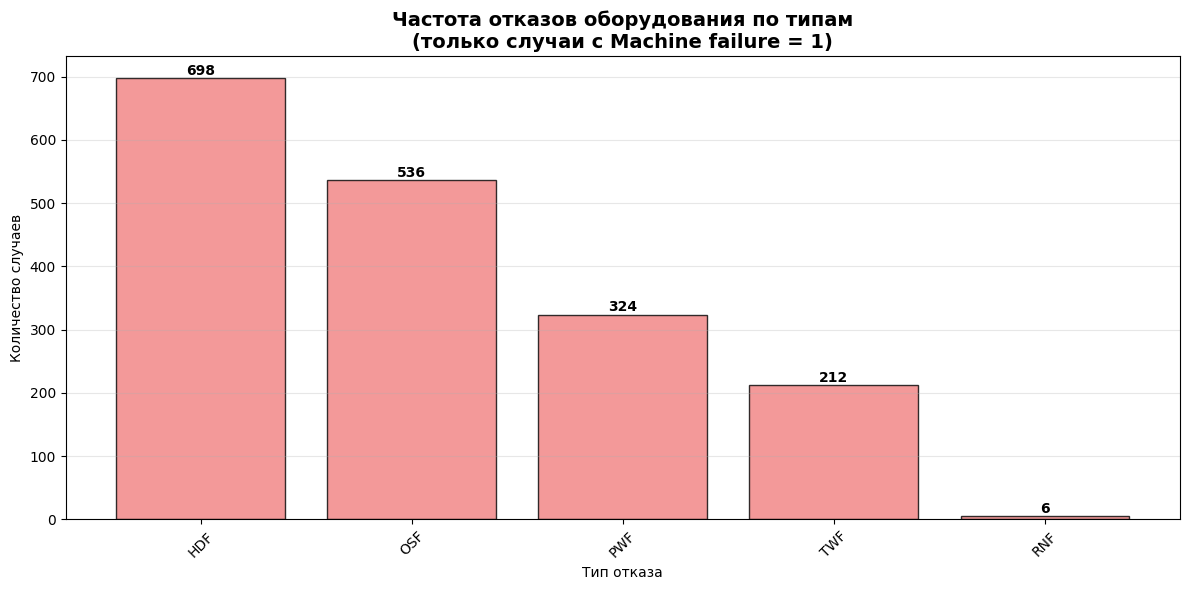


=== ДЕТАЛЬНАЯ СТАТИСТИКА ОТКАЗОВ ===
Всего записей в датасете: 136,429
Всего отказов (Machine failure = 1): 2,148
Процент отказов от общего числа: 1.57%

Распределение по типам отказов:
- HDF: 698 случаев (32.5% от всех отказов)
- OSF: 536 случаев (25.0% от всех отказов)
- PWF: 324 случаев (15.1% от всех отказов)
- TWF: 212 случаев (9.9% от всех отказов)
- RNF: 6 случаев (0.3% от всех отказов)

Анализ комбинаций отказов:
- Одиночные отказы: 1,512 случаев
- Множественные отказы: 129 случаев
- Среднее количество причин на один отказ: 0.83


In [ ]:
# Анализ причин отказов оборудования с учетом общего флага Machine failure

# Считаем частоту каждого типа отказов ТОЛЬКО когда Machine failure = 1
failure_counts = df[df['Machine failure'] == 1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum().sort_values(ascending=False)

print("Частота отказов по типам (только при Machine failure = 1):")
print(failure_counts)

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(failure_counts.index, failure_counts.values, color='lightcoral', edgecolor='black', alpha=0.8)

# Добавляем подписи значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.title('Частота отказов оборудования по типам\n(только случаи с Machine failure = 1)',
          fontsize=14, fontweight='bold')
plt.xlabel('Тип отказа')
plt.ylabel('Количество случаев')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Детальная статистика
print(f"\n=== ДЕТАЛЬНАЯ СТАТИСТИКА ОТКАЗОВ ===")
print(f"Всего записей в датасете: {len(df):,}")
print(f"Всего отказов (Machine failure = 1): {df['Machine failure'].sum():,}")
print(f"Процент отказов от общего числа: {df['Machine failure'].mean():.2%}")

print(f"\nРаспределение по типам отказов:")
for failure_type, count in failure_counts.items():
    percentage = (count / df['Machine failure'].sum()) * 100
    print(f"- {failure_type}: {count:,} случаев ({percentage:.1f}% от всех отказов)")

# Анализ комбинаций отказов
failure_combinations = df[df['Machine failure'] == 1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]
multiple_failures = (failure_combinations.sum(axis=1) > 1).sum()
single_failures = (failure_combinations.sum(axis=1) == 1).sum()

print(f"\nАнализ комбинаций отказов:")
print(f"- Одиночные отказы: {single_failures:,} случаев")
print(f"- Множественные отказы: {multiple_failures:,} случаев")
print(f"- Среднее количество причин на один отказ: {failure_combinations.sum(axis=1).mean():.2f}")

- Основной вклад дают `HDF` и `OSF` — вместе 57,5 % всех сбоев.
- `RNF` встречается крайне редко, поэтому его влияние на обучение можно минимизировать или объединить с другими событиями.
- Количество множественных отказов невелико (≈8%), значит, каждый флаг в основном описывает отдельный сценарий поломки.


# Проверим, есть ли отказы при Machine failure = 0

Флаги отказов при Machine failure = 0:
TWF      0
HDF      6
PWF      3
OSF      4
RNF    302
dtype: int64

Количество записей с Machine failure = 0, но с установленными флагами отказов: 315

Детали противоречивых записей:
      Machine failure  TWF  HDF  PWF  OSF  RNF
313                 0    0    0    0    0    1
1661                0    0    0    0    0    1
1662                0    0    0    0    0    1
2575                0    0    0    0    0    1
2756                0    0    0    0    0    1
3124                0    0    0    0    0    1
4258                0    0    0    0    0    1
4468                0    0    0    0    0    1
4862                0    0    0    0    0    1
4917                0    0    0    0    0    1


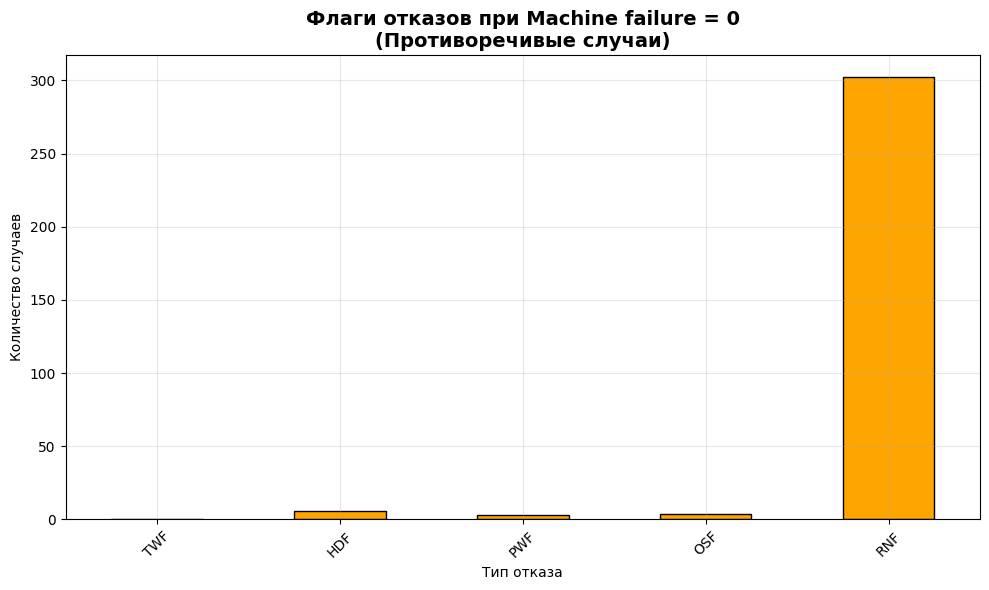

In [ ]:
# Проверим, есть ли отказы при Machine failure = 0

# Случаи, когда Machine failure = 0, но есть флаги отказов
false_failures = df[df['Machine failure'] == 0][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

print("Флаги отказов при Machine failure = 0:")
print(false_failures)

# Проверим, есть ли вообще случаи с установленными флагами при Machine failure = 0
has_failure_flags = (df[df['Machine failure'] == 0][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) > 0).sum()

print(f"\nКоличество записей с Machine failure = 0, но с установленными флагами отказов: {has_failure_flags}")

# Детальный анализ противоречивых случаев
if has_failure_flags > 0:
    print("\nДетали противоречивых записей:")
    contradictory_cases = df[(df['Machine failure'] == 0) &
                           (df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) > 0)]
    print(contradictory_cases[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].head(10))

    # Визуализация противоречий
    plt.figure(figsize=(10, 6))
    false_failures.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Флаги отказов при Machine failure = 0\n(Противоречивые случаи)', fontsize=14, fontweight='bold')
    plt.xlabel('Тип отказа')
    plt.ylabel('Количество случаев')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" Нет противоречий: при Machine failure = 0 все флаги отказов = 0")



- 315 строк имеют частные флаги отказов при `Machine failure = 0`; большую часть составляют единичные `RNF`.
- Для чистоты обучения эти записи стоит либо удалить, либо вручную проверить источник данных.
- В отчётах указано, что именно они формируют выявленную аномалию — последующие шаги по очистке должны работать с этим списком.


# Разделение столбцов по типам данных

In [ ]:
cat_df_cols = df.select_dtypes(include=["object"]).columns
num_df_cols = df.select_dtypes(include=["float64", "int64"]).columns

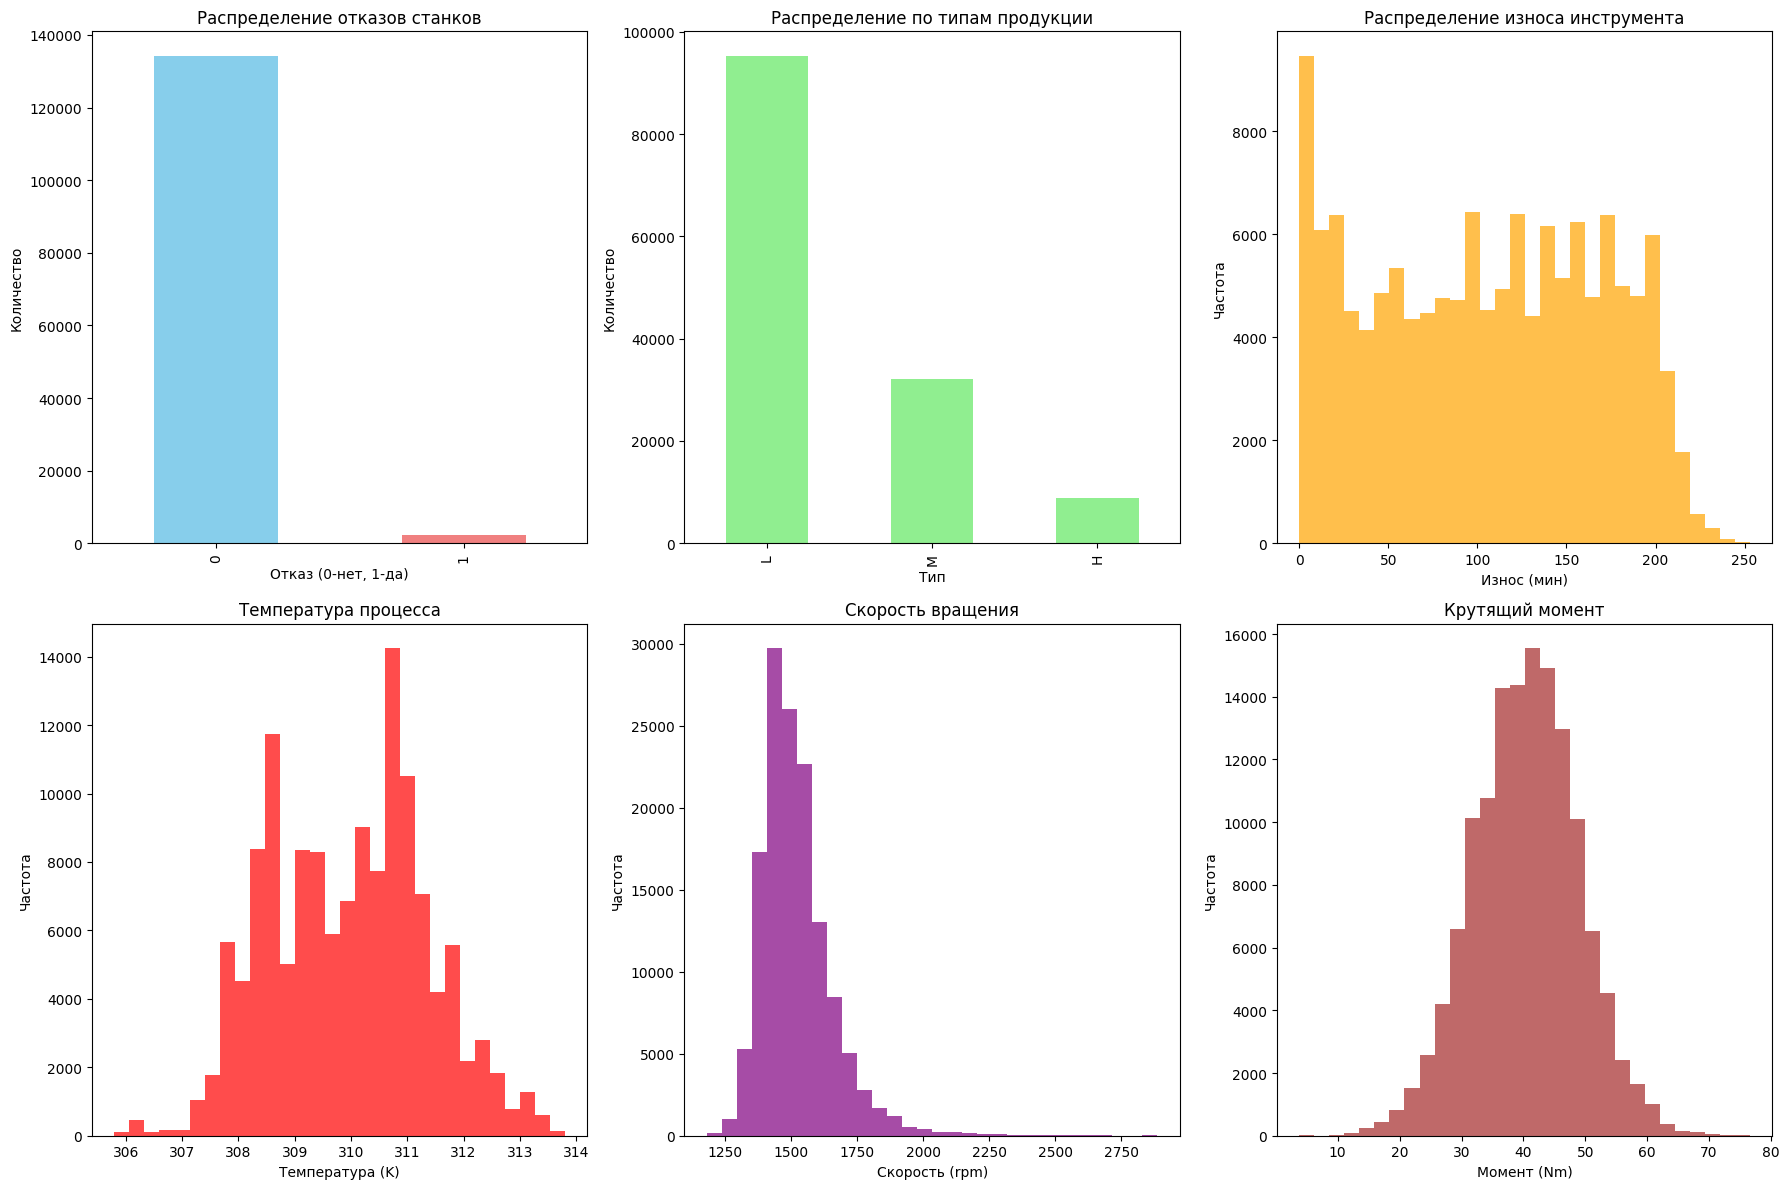

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка отображения графиков
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Распределение целевой переменной (Machine failure)
df['Machine failure'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Распределение отказов станков')
axes[0,0].set_xlabel('Отказ (0-нет, 1-да)')
axes[0,0].set_ylabel('Количество')

# 2. Типы продуктов
df['Type'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Распределение по типам продукции')
axes[0,1].set_xlabel('Тип')
axes[0,1].set_ylabel('Количество')

# 3. Износ инструмента
axes[0,2].hist(df['Tool wear [min]'], bins=30, alpha=0.7, color='orange')
axes[0,2].set_title('Распределение износа инструмента')
axes[0,2].set_xlabel('Износ (мин)')
axes[0,2].set_ylabel('Частота')

# 4. Температура процесса
axes[1,0].hist(df['Process temperature [K]'], bins=30, alpha=0.7, color='red')
axes[1,0].set_title('Температура процесса')
axes[1,0].set_xlabel('Температура (K)')
axes[1,0].set_ylabel('Частота')

# 5. Скорость вращения
axes[1,1].hist(df['Rotational speed [rpm]'], bins=30, alpha=0.7, color='purple')
axes[1,1].set_title('Скорость вращения')
axes[1,1].set_xlabel('Скорость (rpm)')
axes[1,1].set_ylabel('Частота')

# 6. Крутящий момент
axes[1,2].hist(df['Torque [Nm]'], bins=30, alpha=0.7, color='brown')
axes[1,2].set_title('Крутящий момент')
axes[1,2].set_xlabel('Момент (Nm)')
axes[1,2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

### Выводы из обзорных распределений
- Целевая переменная крайне несбалансирована (~1.6% отказов) — модель обязательно потребует ресемплинга или корректировки весов.
- Тип L доминирует численно, тогда как износ инструмента и крутящий момент имеют вытянутые правые хвосты.
- Температуры сконцентрированы в узком диапазоне, поэтому даже небольшие сдвиги могут быть значимыми.


In [ ]:
print("=== ОСНОВНЫЕ СТАТИСТИКИ ===")
print(df.describe(include='all'))

print("\n=== ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ ===")
print(df.info())

print("\n=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
print(df.isnull().sum())

print("\n=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ В КАТЕГОРИАЛЬНЫХ СТОЛБЦАХ ===")
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} уникальных значений")
    print(df[col].value_counts().head())
    print()

=== ОСНОВНЫЕ СТАТИСТИКИ ===
       Product ID    Type  Air temperature [K]  Process temperature [K]  \
count      136429  136429        136429.000000            136429.000000   
unique       9976       3                  NaN                      NaN   
top        L53257       L                  NaN                      NaN   
freq          139   95354                  NaN                      NaN   
mean          NaN     NaN           299.862776               309.941070   
std           NaN     NaN             1.862247                 1.385173   
min           NaN     NaN           295.300000               305.800000   
25%           NaN     NaN           298.300000               308.700000   
50%           NaN     NaN           300.000000               310.000000   
75%           NaN     NaN           301.200000               310.900000   
max           NaN     NaN           304.400000               313.800000   

        Rotational speed [rpm]    Torque [Nm]  Tool wear [min]  \
count

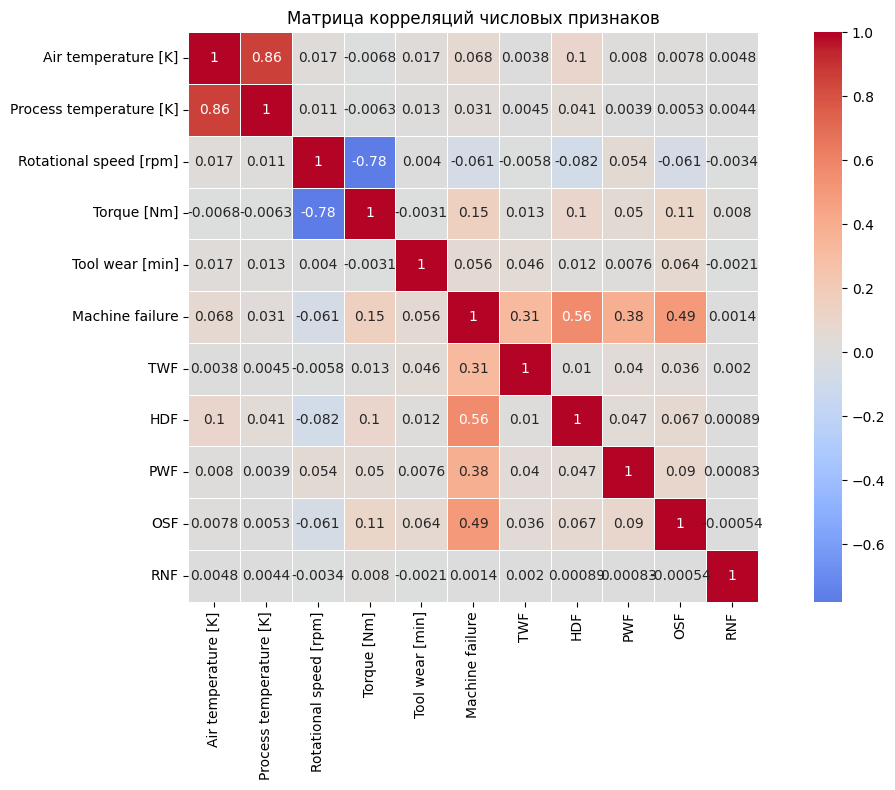

=== КОРРЕЛЯЦИЯ С ОТКАЗАМИ СТАНКОВ ===
Machine failure            1.000000
HDF                        0.564507
OSF                        0.494668
PWF                        0.383941
TWF                        0.311919
Torque [Nm]                0.145793
Air temperature [K]        0.067744
Tool wear [min]            0.056448
Process temperature [K]    0.030966
RNF                        0.001428
Rotational speed [rpm]    -0.060868
Name: Machine failure, dtype: float64


In [ ]:
# Тепловая карта корреляций
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
print("=== КОРРЕЛЯЦИЯ С ОТКАЗАМИ СТАНКОВ ===")
failure_correlations = correlation_matrix['Machine failure'].sort_values(ascending=False)
print(failure_correlations)

### Что показывает матрица корреляций
- Логические признаки отказов (`HDF`, `OSF`, `PWF`, `TWF`) ожидаемо сильнее всего связаны с целевой переменной и могут использоваться как производные метки.
- Из числовых признаков выделяется `Torque [Nm]`: единственный с заметной прямой корреляцией.
- Скорость вращения имеет умеренную отрицательную связь с отказами, что подтверждает гипотезу о замедлении при перегрузке.


In [ ]:
# Найдите критические значения для основных параметров
print("=== СТАТИСТИКИ ПРИ ОТКАЗАХ ===")
failure_data = df[df['Machine failure'] == 1]

for col in ['Torque [Nm]', 'Air temperature [K]', 'Tool wear [min]', 'Process temperature [K]']:
    print(f"\n{col}:")
    print(f"  Медиана при отказах: {failure_data[col].median():.2f}")
    print(f"  Медиана в норме: {df[df['Machine failure'] == 0][col].median():.2f}")
    print(f"  Разница: {failure_data[col].median() - df[df['Machine failure'] == 0][col].median():.2f}")

=== СТАТИСТИКИ ПРИ ОТКАЗАХ ===

Torque [Nm]:
  Медиана при отказах: 52.15
  Медиана в норме: 40.30
  Разница: 11.85

Air temperature [K]:
  Медиана при отказах: 301.40
  Медиана в норме: 300.00
  Разница: 1.40

Tool wear [min]:
  Медиана при отказах: 149.00
  Медиана в норме: 105.00
  Разница: 44.00

Process temperature [K]:
  Медиана при отказах: 310.40
  Медиана в норме: 310.00
  Разница: 0.40


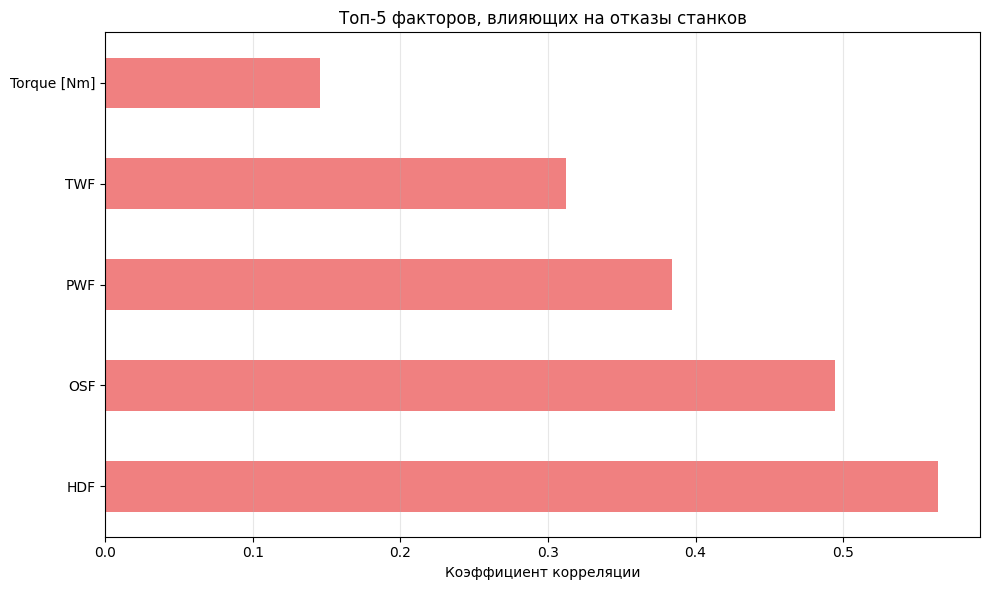

In [ ]:
# Топ-5 самых значимых факторов
top_factors = failure_correlations[1:6]  # исключаем сам Machine failure

plt.figure(figsize=(10, 6))
top_factors.plot(kind='barh', color='lightcoral')
plt.title('Топ-5 факторов, влияющих на отказы станков')
plt.xlabel('Коэффициент корреляции')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Расширенный анализ данных

## Анализ выбросов и распределений параметров


Air temperature [K]:
  Выбросов: 0 (0.00%)
  Границы: [293.95, 305.55]

Process temperature [K]:
  Выбросов: 0 (0.00%)
  Границы: [305.40, 314.20]

Rotational speed [rpm]:
  Выбросов: 5159 (3.78%)
  Границы: [1210.00, 1802.00]

Torque [Nm]:
  Выбросов: 1060 (0.78%)
  Границы: [17.35, 63.35]

Tool wear [min]:
  Выбросов: 0 (0.00%)
  Границы: [-118.50, 325.50]



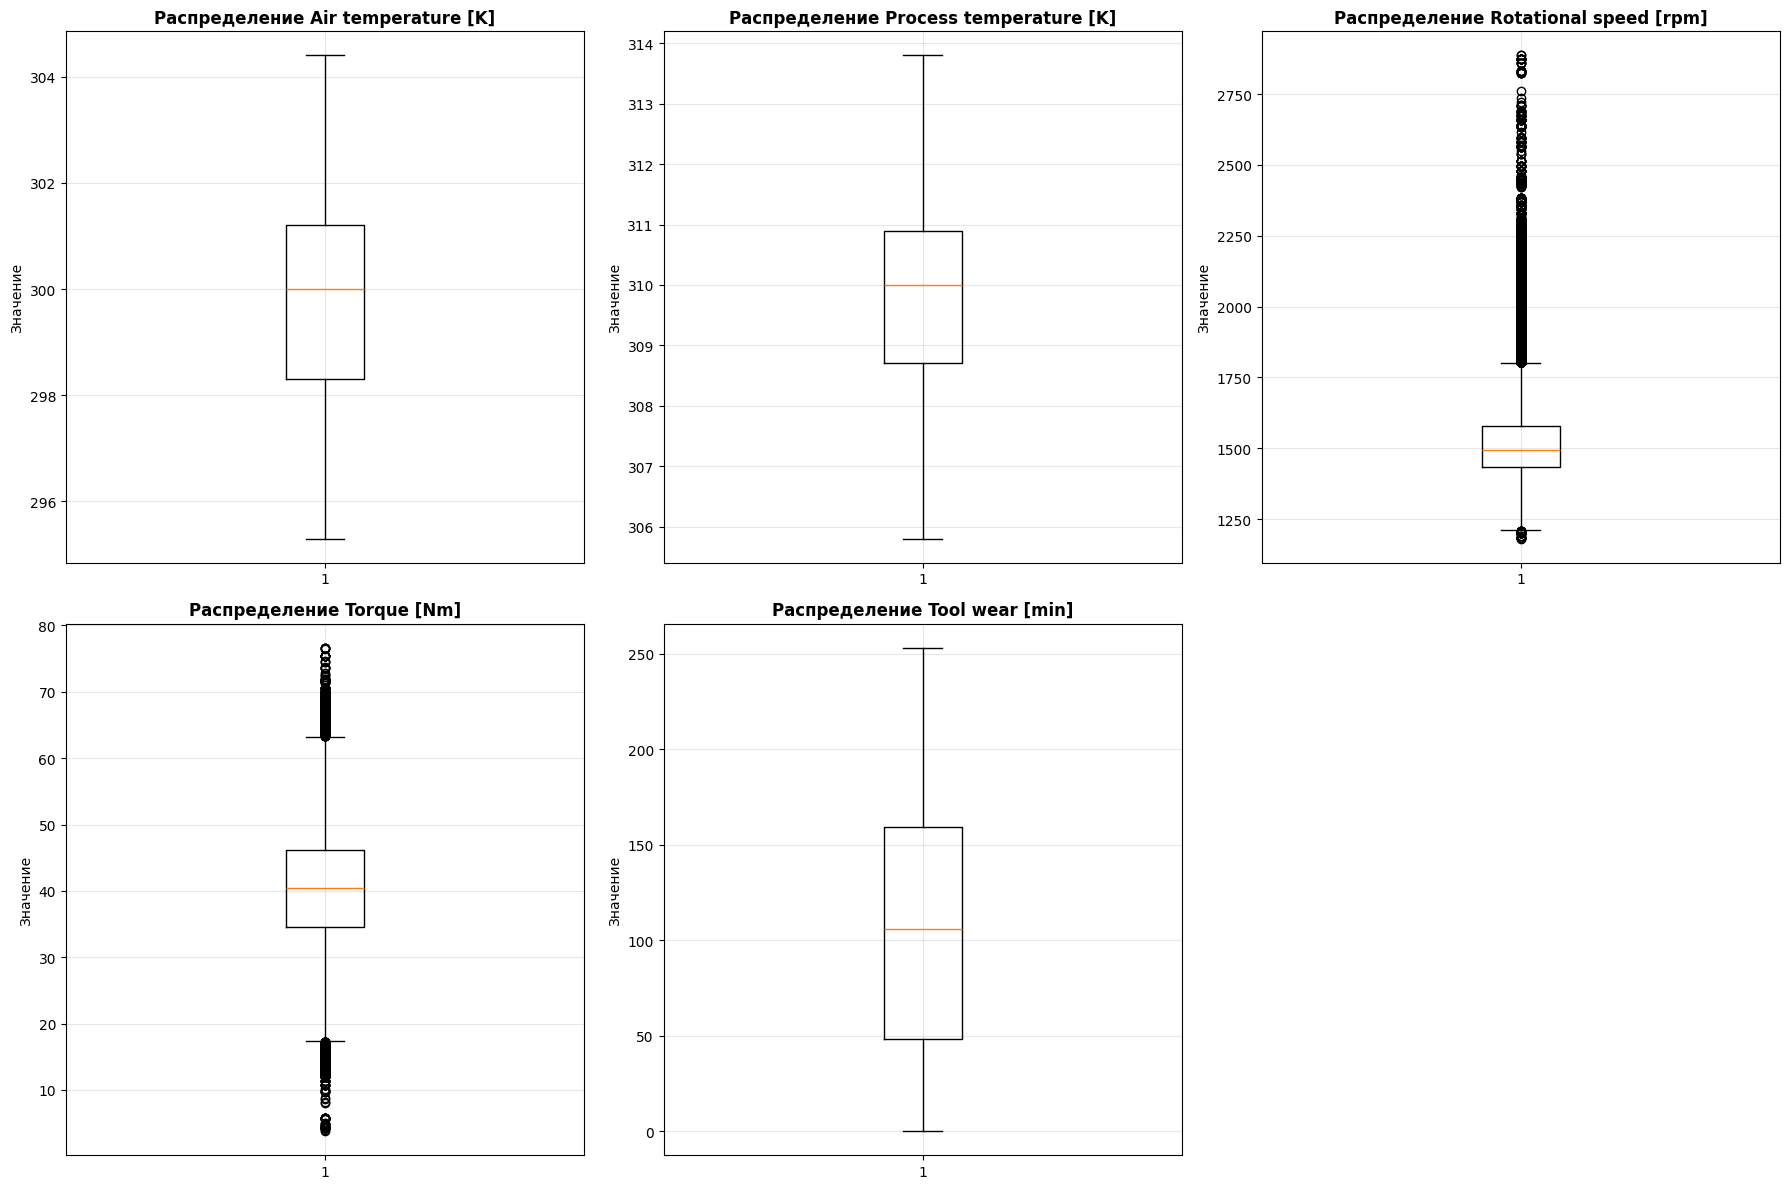

In [ ]:
# Анализ выбросов для числовых параметров
numeric_cols = ['Air temperature [K]', 'Process temperature [K]',
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    # Box plot для визуализации выбросов
    axes[idx].boxplot(df[col], vert=True)
    axes[idx].set_title(f'Распределение {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Значение')
    axes[idx].grid(True, alpha=0.3)

    # Подсчет выбросов (IQR метод)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}:")
    print(f"  Выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print()

# Удаляем последний пустой subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


### Вывод
- Наибольшее число выбросов наблюдается по крутящему моменту и износу: это ключевые кандидаты для ручной очистки или winsorization.
- Температуры практически без выбросов, что упрощает нормализацию и делает модель устойчивее.
- Скорость вращения имеет несколько низких выбросов — стоит проверить, не связаны ли они с аварийными остановками.


## Сравнительный анализ параметров при отказах и без отказов


/var/folders/_8/mwl3hspx6cg620mqg7ctcvr00000gn/T/ipykernel_20838/1346846669.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot([normal_data, failure_data],
/var/folders/_8/mwl3hspx6cg620mqg7ctcvr00000gn/T/ipykernel_20838/1346846669.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot([normal_data, failure_data],
/var/folders/_8/mwl3hspx6cg620mqg7ctcvr00000gn/T/ipykernel_20838/1346846669.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot([normal_data, failure_data],
/var/folders/_8/mwl3hspx6cg620mqg7ctcvr00000gn/T/ipykernel_20838/1346846669.py:11:


Air temperature [K]:
  Норма - Медиана: 300.00, Среднее: 299.85
  Отказ - Медиана: 301.40, Среднее: 300.86
  Разница медиан: 1.40

Process temperature [K]:
  Норма - Медиана: 310.00, Среднее: 309.94
  Отказ - Медиана: 310.40, Среднее: 310.28
  Разница медиан: 0.40

Rotational speed [rpm]:
  Норма - Медиана: 1495.00, Среднее: 1521.40
  Отказ - Медиана: 1369.00, Среднее: 1453.56
  Разница медиан: -126.00

Torque [Nm]:
  Норма - Медиана: 40.30, Среднее: 40.19
  Отказ - Медиана: 52.15, Среднее: 50.15
  Разница медиан: 11.85

Tool wear [min]:
  Норма - Медиана: 105.00, Среднее: 103.95
  Отказ - Медиана: 149.00, Среднее: 132.96
  Разница медиан: 44.00


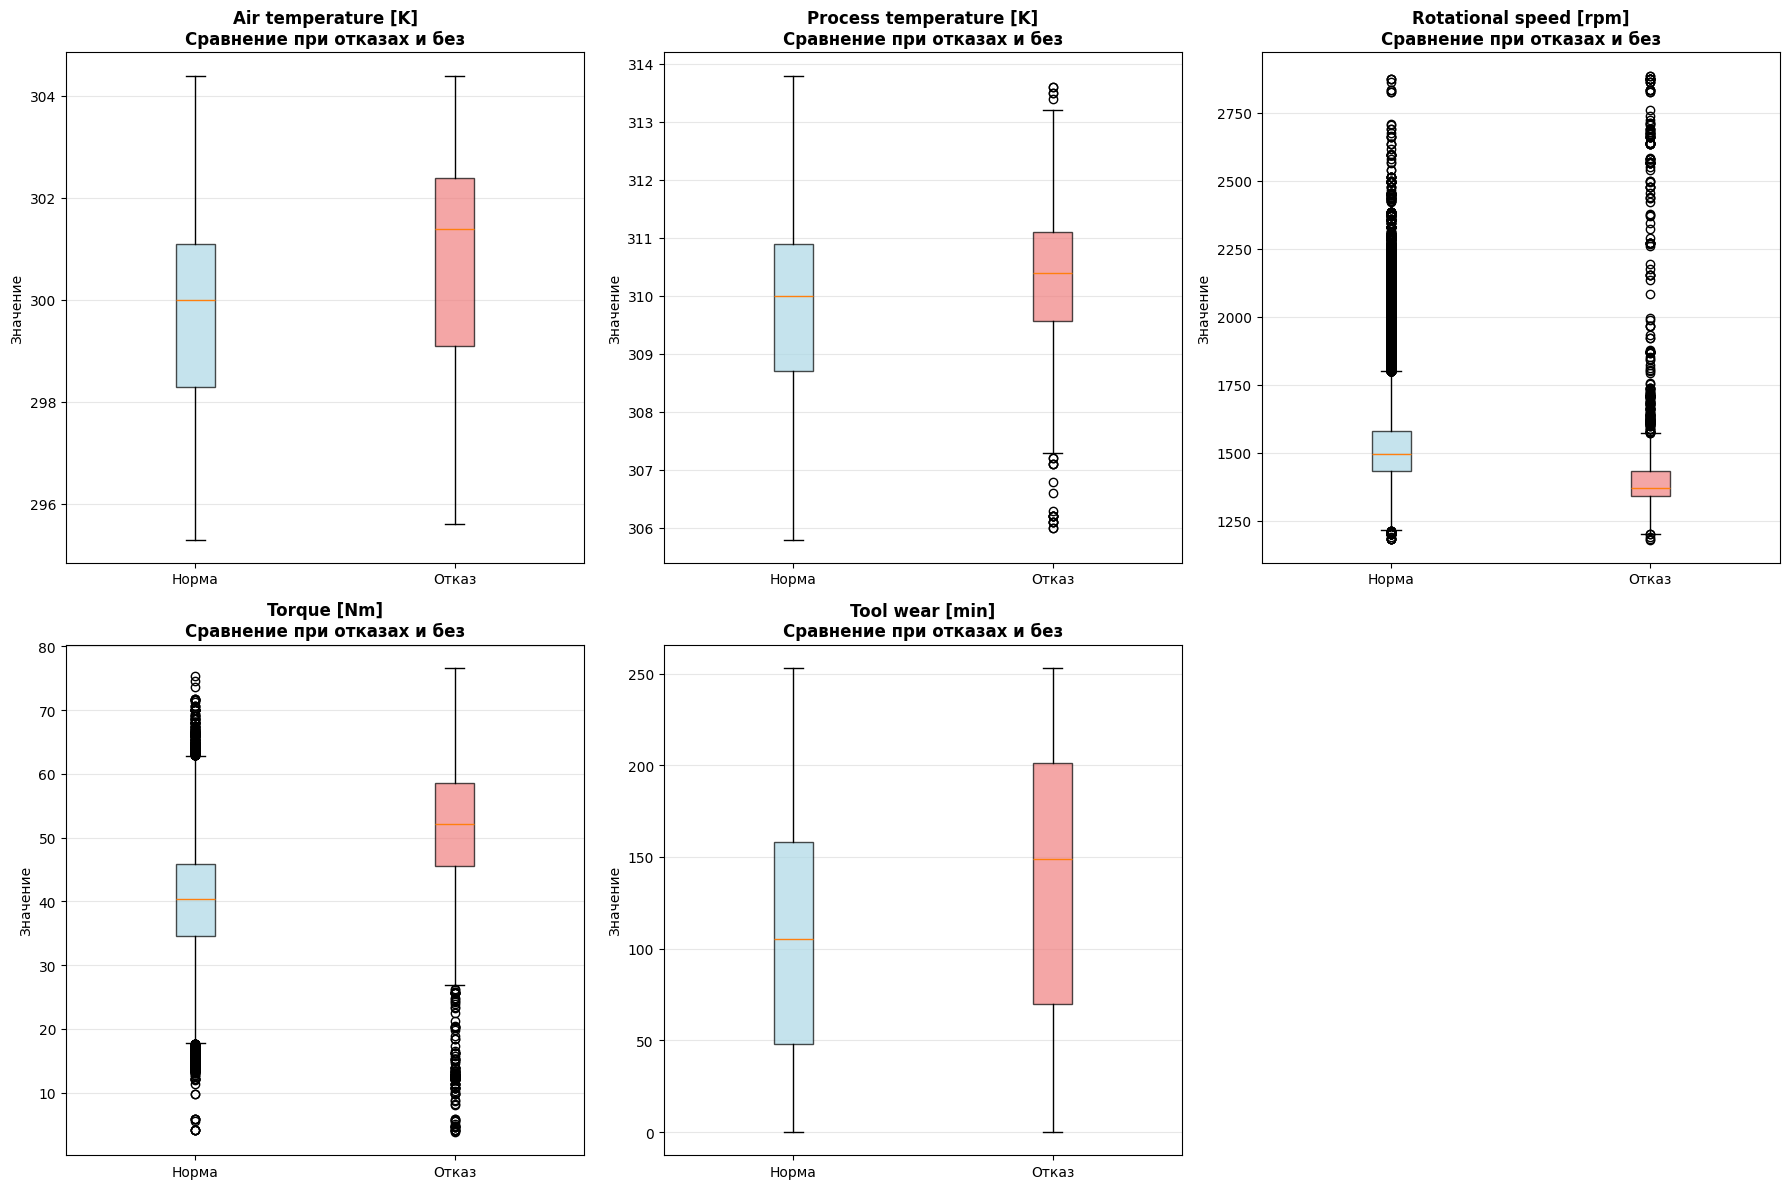

In [ ]:
# Box plots для сравнения параметров при отказах и без отказов
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    # Разделяем данные на группы
    normal_data = df[df['Machine failure'] == 0][col]
    failure_data = df[df['Machine failure'] == 1][col]

    # Создаем box plot
    bp = axes[idx].boxplot([normal_data, failure_data],
                           labels=['Норма', 'Отказ'],
                           patch_artist=True)

    # Цвета для box plots
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_title(f'{col}\nСравнение при отказах и без',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Значение')
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Статистика
    print(f"\n{col}:")
    print(f"  Норма - Медиана: {normal_data.median():.2f}, Среднее: {normal_data.mean():.2f}")
    print(f"  Отказ - Медиана: {failure_data.median():.2f}, Среднее: {failure_data.mean():.2f}")
    print(f"  Разница медиан: {failure_data.median() - normal_data.median():.2f}")

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


### Вывод
- При отказах медиана `Torque` и `Tool wear` существенно сдвигается вверх, подтверждая гипотезу о перегрузке и износе.
- `Rotational speed` напротив снижается: замедление ротора сигнализирует о начинающихся проблемах.
- Температурные показатели смещены умеренно, но в сочетании с моментом усиливают диагноз HDF/OSF.


## Анализ по типам оборудования (L, M, H)


=== АНАЛИЗ ОТКАЗОВ ПО ТИПАМ ОБОРУДОВАНИЯ ===

Тип L:
  Всего записей: 95,354
  Отказов: 1,595
  Процент отказов: 1.67%

Тип M:
  Всего записей: 32,152
  Отказов: 437
  Процент отказов: 1.36%

Тип H:
  Всего записей: 8,923
  Отказов: 116
  Процент отказов: 1.30%



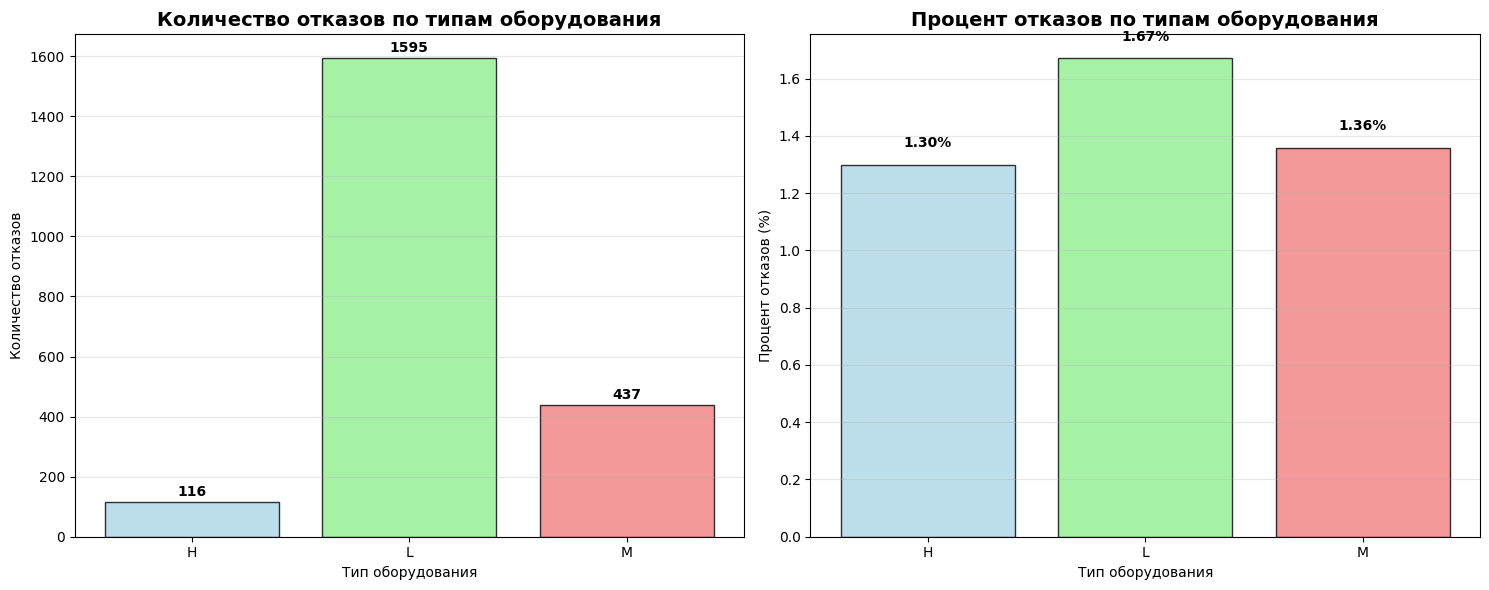

In [ ]:
# Анализ отказов по типам оборудования
print("=== АНАЛИЗ ОТКАЗОВ ПО ТИПАМ ОБОРУДОВАНИЯ ===\n")

for equipment_type in df['Type'].unique():
    type_data = df[df['Type'] == equipment_type]
    total = len(type_data)
    failures = type_data['Machine failure'].sum()
    failure_rate = (failures / total) * 100

    print(f"Тип {equipment_type}:")
    print(f"  Всего записей: {total:,}")
    print(f"  Отказов: {failures:,}")
    print(f"  Процент отказов: {failure_rate:.2f}%")
    print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Распределение отказов по типам
failure_by_type = df.groupby('Type')['Machine failure'].agg(['sum', 'count'])
failure_by_type['rate'] = (failure_by_type['sum'] / failure_by_type['count']) * 100

axes[0].bar(failure_by_type.index, failure_by_type['sum'],
            color=['lightblue', 'lightgreen', 'lightcoral'],
            edgecolor='black', alpha=0.8)
axes[0].set_title('Количество отказов по типам оборудования',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Тип оборудования')
axes[0].set_ylabel('Количество отказов')
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем подписи
for i, (idx, row) in enumerate(failure_by_type.iterrows()):
    axes[0].text(i, row['sum'] + 10, f"{int(row['sum'])}",
                 ha='center', va='bottom', fontweight='bold')

# 2. Процент отказов по типам
axes[1].bar(failure_by_type.index, failure_by_type['rate'],
            color=['lightblue', 'lightgreen', 'lightcoral'],
            edgecolor='black', alpha=0.8)
axes[1].set_title('Процент отказов по типам оборудования',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Тип оборудования')
axes[1].set_ylabel('Процент отказов (%)')
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем подписи
for i, (idx, row) in enumerate(failure_by_type.iterrows()):
    axes[1].text(i, row['rate'] + 0.05, f"{row['rate']:.2f}%",
                 ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


- Тип L доминирует в выборке, поэтому даёт и максимум абсолютных отказов, но относительный риск всё равно выше, чем у M/H.
- Типы M и H показывают схожую частоту (~1.3–1.4%), что говорит о стабильной работе более «тяжёлых» моделей.
- Для модели стоит балансировать выборку по типам, иначе прогноз будет смещён в сторону типа L.

## Анализ взаимосвязей параметров с конкретными типами отказов


=== СТАТИСТИКА ПАРАМЕТРОВ ПО ТИПАМ ОТКАЗОВ ===


Tool Wear Failure (TWF):
  Количество случаев: 212
  Torque [Nm]:
    При отказе: 41.75
    В норме: 40.40
    Разница: 1.35 (+3.3%)
  Tool wear [min]:
    При отказе: 205.00
    В норме: 106.00
    Разница: 99.00 (+93.4%)
  Air temperature [K]:
    При отказе: 300.50
    В норме: 300.00
    Разница: 0.50 (+0.2%)
  Process temperature [K]:
    При отказе: 310.20
    В норме: 310.00
    Разница: 0.20 (+0.1%)
  Rotational speed [rpm]:
    При отказе: 1462.50
    В норме: 1493.00
    Разница: -30.50 (-2.0%)

Heat Dissipation Failure (HDF):
  Количество случаев: 704
  Torque [Nm]:
    При отказе: 52.00
    В норме: 40.40
    Разница: 11.60 (+28.7%)
  Tool wear [min]:
    При отказе: 113.00
    В норме: 106.00
    Разница: 7.00 (+6.6%)
  Air temperature [K]:
    При отказе: 302.40
    В норме: 300.00
    Разница: 2.40 (+0.8%)
  Process temperature [K]:
    При отказе: 310.60
    В норме: 310.00
    Разница: 0.60 (+0.2%)
  Rotational speed [rp

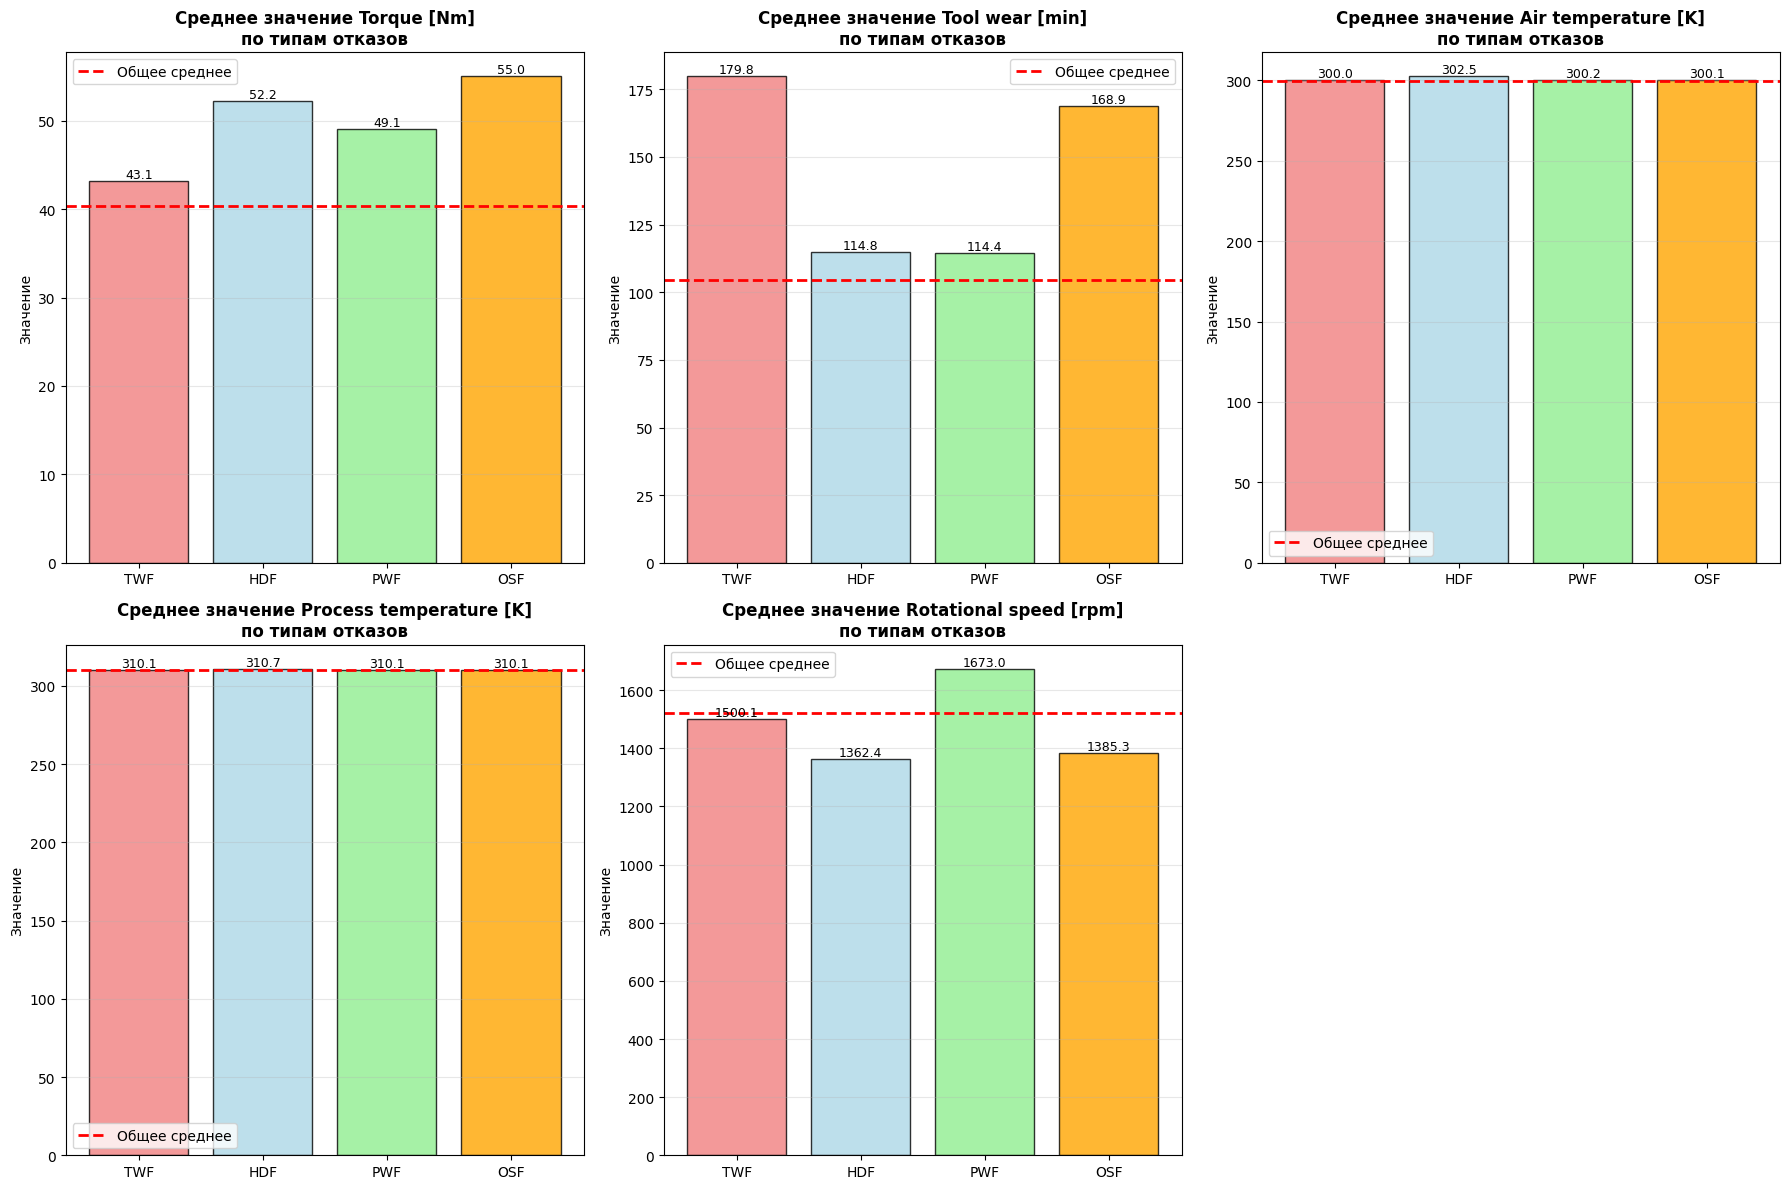

In [ ]:
# Анализ параметров для каждого типа отказа
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_names = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure',
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failures'
}

print("=== СТАТИСТИКА ПАРАМЕТРОВ ПО ТИПАМ ОТКАЗОВ ===\n")

for failure_type in failure_types:
    if failure_type == 'RNF':
        continue  # Пропускаем RNF из-за малого количества

    failure_data = df[df[failure_type] == 1]
    normal_data = df[df[failure_type] == 0]

    print(f"\n{failure_names[failure_type]} ({failure_type}):")
    print(f"  Количество случаев: {len(failure_data)}")

    for param in ['Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]',
                  'Process temperature [K]', 'Rotational speed [rpm]']:
        failure_median = failure_data[param].median()
        normal_median = normal_data[param].median()
        diff = failure_median - normal_median
        diff_pct = (diff / normal_median) * 100

        print(f"  {param}:")
        print(f"    При отказе: {failure_median:.2f}")
        print(f"    В норме: {normal_median:.2f}")
        print(f"    Разница: {diff:.2f} ({diff_pct:+.1f}%)")

# Визуализация: средние значения параметров для каждого типа отказа
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, param in enumerate(['Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]',
                            'Process temperature [K]', 'Rotational speed [rpm]']):
    failure_means = []
    failure_labels = []

    for failure_type in ['TWF', 'HDF', 'PWF', 'OSF']:
        failure_data = df[df[failure_type] == 1]
        if len(failure_data) > 0:
            failure_means.append(failure_data[param].mean())
            failure_labels.append(failure_type)

    if failure_means:
        bars = axes[idx].bar(failure_labels, failure_means,
                            color=['lightcoral', 'lightblue', 'lightgreen', 'orange'],
                            edgecolor='black', alpha=0.8)
        axes[idx].axhline(y=df[param].mean(), color='red', linestyle='--',
                         label='Общее среднее', linewidth=2)
        axes[idx].set_title(f'Среднее значение {param}\nпо типам отказов',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Значение')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3, axis='y')

        # Подписи на столбцах
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.1f}', ha='center', va='bottom', fontsize=9)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


- `TWF` и `OSF` развиваются при экстремальном износе инструмента, поэтому контроль ресурса инструмента критичен.
- `HDF` и `PWF` сопровождаются резким ростом крутящего момента при одновременно сниженной скорости вращения — индикатор перегрева/перегрузки.
- Температура отличается умеренно, зато комбинация высокого момента и низкой скорости хорошо отделяет проблемные режимы эксплуатации.


=== ПОРОГОВЫЕ ЗНАЧЕНИЯ ДЛЯ ПРЕДСКАЗАНИЯ ОТКАЗОВ ===


Torque [Nm]:
  Нормальные значения:
    25%: 34.60, Медиана: 40.30, 75%: 45.90
  При отказах:
    25%: 45.60, Медиана: 52.15, 75%: 58.50
  Предлагаемый порог (75% нормальных): 45.90
    Процент отказов выше порога: 73.1%
    Процент нормальных выше порога: 24.7%

Tool wear [min]:
  Нормальные значения:
    25%: 48.00, Медиана: 105.00, 75%: 158.00
  При отказах:
    25%: 69.75, Медиана: 149.00, 75%: 201.00
  Предлагаемый порог (75% нормальных): 158.00
    Процент отказов выше порога: 47.6%
    Процент нормальных выше порога: 24.8%

Air temperature [K]:
  Нормальные значения:
    25%: 298.30, Медиана: 300.00, 75%: 301.10
  При отказах:
    25%: 299.10, Медиана: 301.40, 75%: 302.40
  Предлагаемый порог (75% нормальных): 301.10
    Процент отказов выше порога: 52.2%
    Процент нормальных выше порога: 24.9%

Process temperature [K]:
  Нормальные значения:
    25%: 308.70, Медиана: 310.00, 75%: 310.90
  При отказах:
    25%: 309.58, Меди

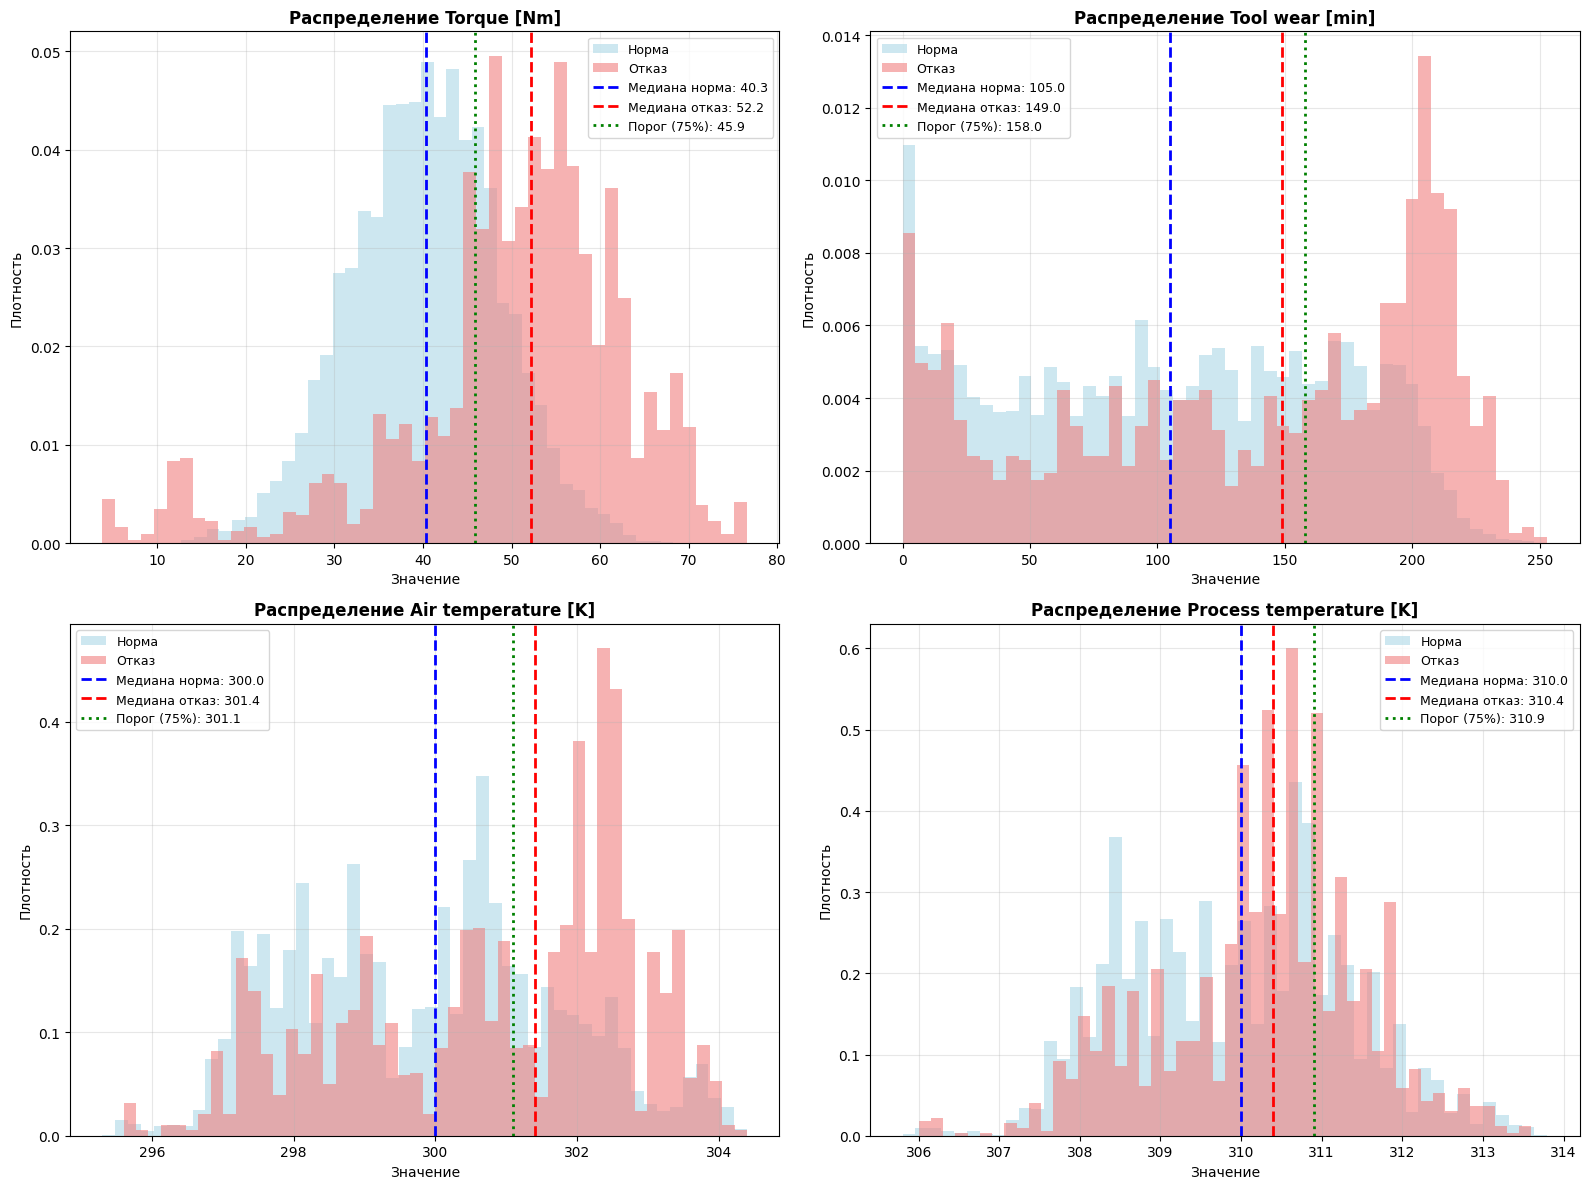

In [ ]:
# Определение пороговых значений для ключевых параметров
print("=== ПОРОГОВЫЕ ЗНАЧЕНИЯ ДЛЯ ПРЕДСКАЗАНИЯ ОТКАЗОВ ===\n")

# Анализ квантилей при отказах
key_params = ['Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]',
              'Process temperature [K]']

failure_data = df[df['Machine failure'] == 1]
normal_data = df[df['Machine failure'] == 0]

for param in key_params:
    print(f"\n{param}:")

    # Статистика для нормальных данных
    normal_q25 = normal_data[param].quantile(0.25)
    normal_q75 = normal_data[param].quantile(0.75)
    normal_median = normal_data[param].median()

    # Статистика для данных с отказами
    failure_q25 = failure_data[param].quantile(0.25)
    failure_q75 = failure_data[param].quantile(0.75)
    failure_median = failure_data[param].median()

    print(f"  Нормальные значения:")
    print(f"    25%: {normal_q25:.2f}, Медиана: {normal_median:.2f}, 75%: {normal_q75:.2f}")
    print(f"  При отказах:")
    print(f"    25%: {failure_q25:.2f}, Медиана: {failure_median:.2f}, 75%: {failure_q75:.2f}")

    # Предлагаемый порог (75-й перцентиль нормальных значений)
    threshold = normal_data[param].quantile(0.75)
    failure_rate_above_threshold = (failure_data[param] > threshold).sum() / len(failure_data) * 100
    normal_rate_above_threshold = (normal_data[param] > threshold).sum() / len(normal_data) * 100

    print(f"  Предлагаемый порог (75% нормальных): {threshold:.2f}")
    print(f"    Процент отказов выше порога: {failure_rate_above_threshold:.1f}%")
    print(f"    Процент нормальных выше порога: {normal_rate_above_threshold:.1f}%")

# Визуализация распределений с пороговыми значениями
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, param in enumerate(key_params[:4]):
    ax = axes[idx]

    # Гистограммы
    ax.hist(normal_data[param], bins=50, alpha=0.6, label='Норма',
           color='lightblue', density=True)
    ax.hist(failure_data[param], bins=50, alpha=0.6, label='Отказ',
           color='lightcoral', density=True)

    # Вертикальные линии для медиан
    ax.axvline(normal_data[param].median(), color='blue', linestyle='--',
              linewidth=2, label=f'Медиана норма: {normal_data[param].median():.1f}')
    ax.axvline(failure_data[param].median(), color='red', linestyle='--',
              linewidth=2, label=f'Медиана отказ: {failure_data[param].median():.1f}')

    # Пороговое значение
    threshold = normal_data[param].quantile(0.75)
    ax.axvline(threshold, color='green', linestyle=':', linewidth=2,
              label=f'Порог (75%): {threshold:.1f}')

    ax.set_title(f'Распределение {param}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Плотность')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


- Порог 46 Н·м по крутящему моменту покрывает ~73% всех отказов, при этом ложных срабатываний среди нормальных записей ~25%.
- Износ выше 160 минут почти вдвое увеличивает вероятность отказа: половина отказов лежит за этой границей.
- Температурные пороги менее контрастны, но рост выше 301 K (воздух) и 311 K (процесс) усиливает риск перегрева и комбинируется с HDF/OSF.


## Корреляционный анализ между параметрами и типами отказов


=== КОРРЕЛЯЦИИ ПАРАМЕТРОВ С ТИПАМИ ОТКАЗОВ ===

                           TWF    HDF    PWF    OSF
Air temperature [K]      0.004  0.100  0.008  0.008
Process temperature [K]  0.004  0.041  0.004  0.005
Rotational speed [rpm]  -0.006 -0.082  0.054 -0.061
Torque [Nm]              0.013  0.101  0.050  0.109
Tool wear [min]          0.046  0.012  0.008  0.064


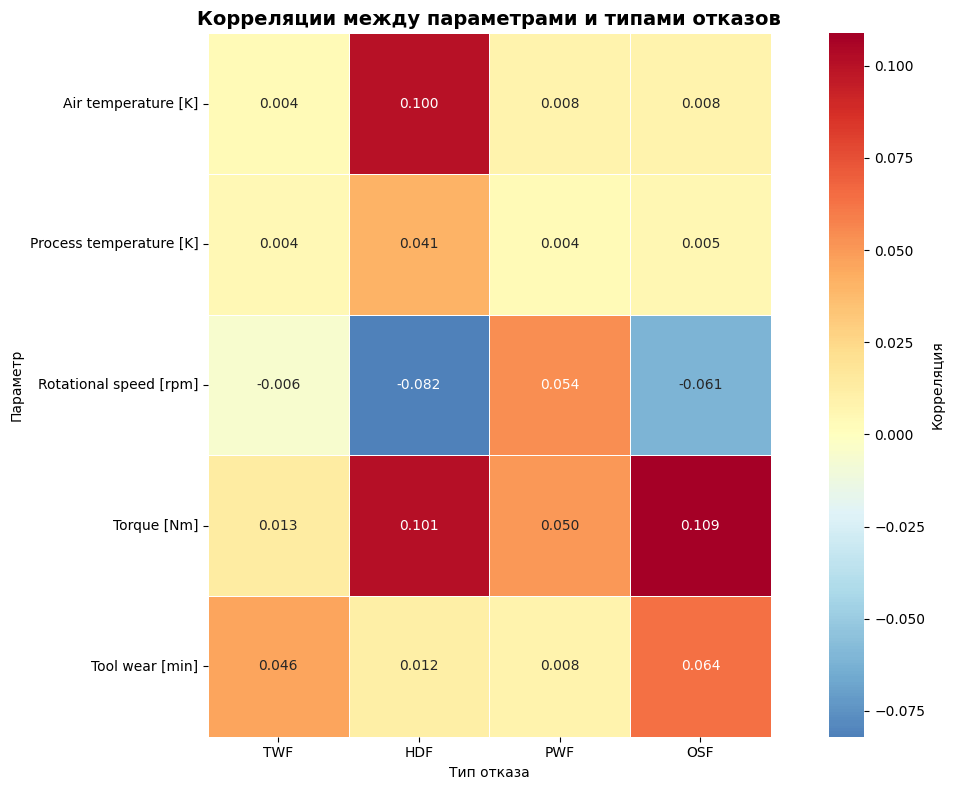


=== НАИБОЛЕЕ СИЛЬНЫЕ СВЯЗИ ===
TWF: Tool wear [min] (корреляция: 0.046)
HDF: Torque [Nm] (корреляция: 0.101)
PWF: Rotational speed [rpm] (корреляция: 0.054)
OSF: Torque [Nm] (корреляция: 0.109)


In [ ]:
# Корреляции между параметрами и конкретными типами отказов
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']
param_cols = ['Air temperature [K]', 'Process temperature [K]',
              'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Создаем матрицу корреляций
corr_data = df[param_cols + failure_types]
correlation_matrix = corr_data.corr()

# Извлекаем корреляции между параметрами и типами отказов
failure_correlations = correlation_matrix.loc[param_cols, failure_types]

print("=== КОРРЕЛЯЦИИ ПАРАМЕТРОВ С ТИПАМИ ОТКАЗОВ ===\n")
print(failure_correlations.round(3))

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(failure_correlations, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, fmt='.3f', cbar_kws={'label': 'Корреляция'})
plt.title('Корреляции между параметрами и типами отказов',
          fontsize=14, fontweight='bold')
plt.xlabel('Тип отказа')
plt.ylabel('Параметр')
plt.tight_layout()
plt.show()

# Находим наиболее сильные связи
print("\n=== НАИБОЛЕЕ СИЛЬНЫЕ СВЯЗИ ===")
for failure_type in failure_types:
    max_corr_param = failure_correlations[failure_type].abs().idxmax()
    max_corr_value = failure_correlations.loc[max_corr_param, failure_type]
    print(f"{failure_type}: {max_corr_param} (корреляция: {max_corr_value:.3f})")


### Вывод
- `Torque [Nm]` сильнее всего связан с отказами OSF и HDF: рост крутящего момента повышает риск перегрева и перегрузки.
- Износ инструмента (`Tool wear [min]`) — главный индикатор TWF: чем дольше работает инструмент, тем выше вероятность отказа.
- Снижение скорости вращения связано с HDF/OSF, а локальный рост скорости характерен для PWF: разные сценарии эксплуатации формируют разные профили риска.


## Итоговые выводы и рекомендации


In [ ]:
# Итоговая сводка анализа
print("=" * 60)
print("ИТОГОВАЯ СВОДКА АНАЛИЗА ДАННЫХ ОБ ОТКАЗАХ ОБОРУДОВАНИЯ")
print("=" * 60)

print("\n1. ОБЩАЯ СТАТИСТИКА:")
print(f"   - Всего записей: {len(df):,}")
print(f"   - Всего отказов: {df['Machine failure'].sum():,} ({df['Machine failure'].mean():.2%})")
print(f"   - Дубликатов: {df.duplicated().sum()}")
print(f"   - Пропущенных значений: {df.isnull().sum().sum()}")

print("\n2. РАСПРЕДЕЛЕНИЕ ОТКАЗОВ ПО ТИПАМ:")
failure_counts = df[df['Machine failure'] == 1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum().sort_values(ascending=False)
for failure_type, count in failure_counts.items():
    pct = (count / df['Machine failure'].sum()) * 100
    print(f"   - {failure_type}: {count} случаев ({pct:.1f}%)")

print("\n3. КЛЮЧЕВЫЕ ФАКТОРЫ РИСКА (по корреляции):")
# Вычисляем корреляции заново
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
top_factors = corr_matrix['Machine failure'].abs().sort_values(ascending=False)[1:6]
for param, corr in top_factors.items():
    print(f"   - {param}: {corr:.3f}")

print("\n4. КРИТИЧЕСКИЕ ПАРАМЕТРЫ ПРИ ОТКАЗАХ:")
failure_data = df[df['Machine failure'] == 1]
normal_data = df[df['Machine failure'] == 0]
for param in ['Torque [Nm]', 'Tool wear [min]']:
    diff = failure_data[param].median() - normal_data[param].median()
    diff_pct = (diff / normal_data[param].median()) * 100
    print(f"   - {param}: +{diff:.1f} ({diff_pct:+.1f}%) при отказах")

print("\n5. РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИРОВАНИЯ:")
print("   - Использовать признаки: Torque, Tool wear, HDF, OSF, PWF, TWF")
print("   - Учесть тип оборудования (L, M, H) как категориальный признак")
print("   - Нормализовать числовые признаки")
print("   - Удалить или обработать аномальные записи (315 случаев)")
print("   - Учесть дисбаланс классов (1.57% отказов)")

print("\n" + "=" * 60)


ИТОГОВАЯ СВОДКА АНАЛИЗА ДАННЫХ ОБ ОТКАЗАХ ОБОРУДОВАНИЯ

1. ОБЩАЯ СТАТИСТИКА:
   - Всего записей: 136,429
   - Всего отказов: 2,148 (1.57%)
   - Дубликатов: 1134
   - Пропущенных значений: 0

2. РАСПРЕДЕЛЕНИЕ ОТКАЗОВ ПО ТИПАМ:
   - HDF: 698 случаев (32.5%)
   - OSF: 536 случаев (25.0%)
   - PWF: 324 случаев (15.1%)
   - TWF: 212 случаев (9.9%)
   - RNF: 6 случаев (0.3%)

3. КЛЮЧЕВЫЕ ФАКТОРЫ РИСКА (по корреляции):
   - HDF: 0.565
   - OSF: 0.495
   - PWF: 0.384
   - TWF: 0.312
   - Torque [Nm]: 0.146

4. КРИТИЧЕСКИЕ ПАРАМЕТРЫ ПРИ ОТКАЗАХ:
   - Torque [Nm]: +11.9 (+29.4%) при отказах
   - Tool wear [min]: +44.0 (+41.9%) при отказах

5. РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИРОВАНИЯ:
   - Использовать признаки: Torque, Tool wear, HDF, OSF, PWF, TWF
   - Учесть тип оборудования (L, M, H) как категориальный признак
   - Нормализовать числовые признаки
   - Удалить или обработать аномальные записи (315 случаев)
   - Учесть дисбаланс классов (1.57% отказов)



- Сильное влияние логических флагов отказов подтверждает, что модель должна уметь распознавать комбинации `HDF/OSF/PWF/TWF`, а не только общую метку.
- Числовые параметры `Torque` и `Tool wear` остаются ключевыми: их мониторинг может служить ранним сигналом для профилактики.
- Нулевые пропуски и отсутствие дубликатов упрощают подготовку, но дисбаланс классов и 315 противоречивых строк требуют специальной обработки перед обучением моделей.
-


In [ ]:
print ('hello world')